In [13]:
import numpy as np #work with arrays
import matplotlib.pyplot as plt #to plot graphs in python
import h5py #to interact with dataset(.h5 files)
import scipy #to test my model with my own set of pictures
from PIL import Image #same as scipy
from scipy import ndimage

Loading the Dataset

In [14]:
def load_dataset():

    with h5py.File('../Cat_Identification/Dataset/train_catvnoncat.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File('../Cat_Identification/Dataset/test_catvnoncat.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Example of a image in the dataset

y = [1], it's a 'cat' picture.


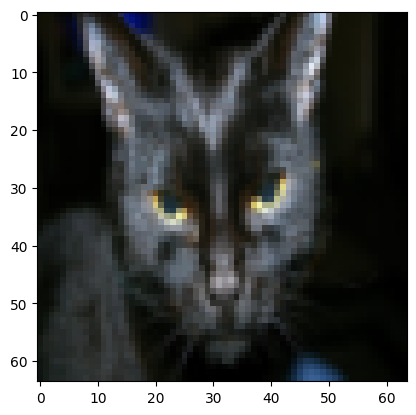

In [15]:
index=25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [16]:
m_train=train_set_x_orig.shape[0] #number of training examples
m_test=test_set_x_orig.shape[0] #number of test examples
num_px=train_set_x_orig.shape[1] #height=width of a training image
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Reshape both train and test arrays to (single column * no of entries)(single column for image)

In [17]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


Normalize our training and testing arrays

In [18]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

Sigmoid Function

In [19]:
def sigmoid(z):
    s=1/(1+np.exp(-z))
    return s
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2])))) #just to check

sigmoid([0, 2]) = [0.5        0.88079708]


To initialize w and b (to initialize parameters to start training our datatset)

In [20]:
def initialize_with_zeros(dim):
    w = np.zeros(shape=(dim, 1)) #w is initialized as a 0 vector of (x(dim),1)
    b = 0
    assert(w.shape == (dim, 1)) #assertions gives an error if condition not satisfied
    assert(isinstance(b, float) or isinstance(b, int)) #b should be a float or a integer
    return w,b
w, b = initialize_with_zeros(2) #just to check
print ("w(shape) = " + str(w.shape))
print ("b = " + str(b))

w(shape) = (2, 1)
b = 0


Forward and Backward Propogating our Neural Network


In [21]:
def propagate(w,b,X,Y):
    m=X.shape[1] #to calculate total examples
    #forward propogation
    A = sigmoid(np.dot(w.T, X)+b) 
    cost = (1/m)*np.sum(-Y*np.log(A)-(1-Y)*np.log(1-A))
    #backward propogation
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {"dw": dw,
             "db": db}
    return grads, cost

In [22]:
#to test our function
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


Optimization of our Parameters

In [23]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs=[]
    for i in range(num_iterations):
        #for each iteration calculate dw and db
        grads, cost =propagate(w,b,X,Y)
        dw=grads["dw"]
        db=grads["db"]
        #update values
        w=w-learning_rate*dw
        b=b-learning_rate*db
        #append on every 100 iteration
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs
        

In [24]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


Now we use these parameters to predict test dataset output

In [25]:
def predict(w,b,X):
    m=X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    #start
    A = sigmoid(np.dot(w.T, X)+b)
    #check for eache iteration
    for i in range(A.shape[1]):
        if A[0,i]<=0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
        pass
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [26]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


Run Entire Model Now

In [27]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    w,b=initialize_with_zeros(X_train.shape[0])
    w=w.reshape(X_train.shape[0],1)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = False)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


Plot Learning Curve


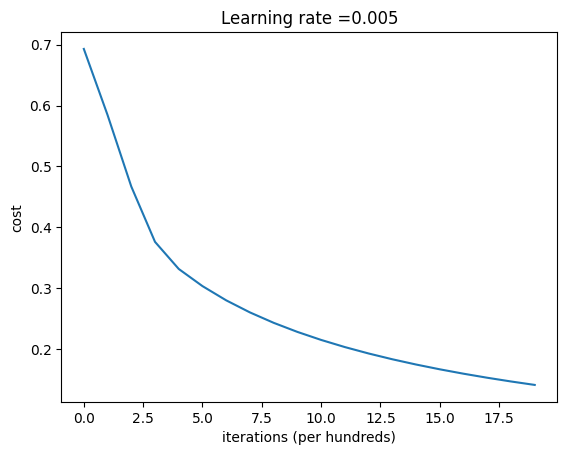

In [28]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

To Run with your own image

C:\Users\Daksh Raheja\AppData\Local\Temp\ipykernel_10476\3995743496.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(fname))


y = 1.0, your algorithm predicts a "cat" picture.


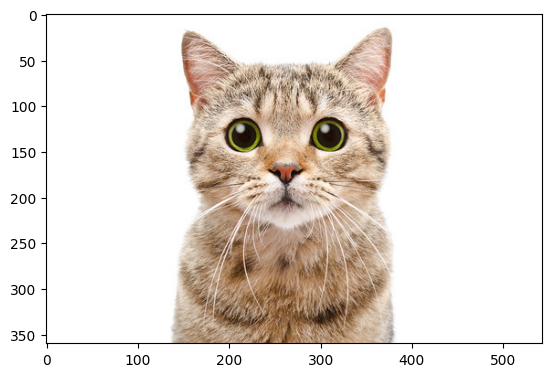

In [29]:
import imageio
from skimage.transform import resize
my_image = '../Cat_Identification/Images/cat.jpg'

# We preprocess the image to fit your algorithm.
fname = my_image
image = np.array(imageio.imread(fname))
image = image/255.
my_image = resize(image, (num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")